# State characterization

In [1]:
""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd

# --Machine learning and statistics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

from one.api import ONE
from jax import vmap
from pprint import pprint
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from dynamax.hidden_markov_model import GaussianHMM

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
#functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from fitting_functions import cross_validate_model
os.chdir(functions_path)
from plotting_functions import plot_transition_mat, plot_states_aligned, params_to_df, align_bin_design_matrix, states_per_trial_phase, plot_states_aligned_trial, traces_over_sates

one = ONE()


RuntimeError: This version of jaxlib was built using AVX instructions, which your CPU and/or operating system do not support. You may be able work around this issue by building jaxlib from source.

## Parameters

In [ ]:
bin_size = 0.1
num_iters = 100
num_train_batches = 5
method = 'kmeans'

var_names = ['avg_wheel_vel', 'pupil_diameter',
       'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
       'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
       'pupil_speed_Y', 'Gaussian_licks']

### Get design matrices

In [ ]:
data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + str(bin_size) + '/'
os.chdir(data_path)
design_matrices = os.listdir(data_path)

## Preprocess list of design matrices

In [2]:
# Save data of all sessions for latter
matrix_all = defaultdict(list)
matrix_all_unnorm = defaultdict(list)
session_all = defaultdict(list)

for m, mat in enumerate(design_matrices[0:2]):
   
    # Trials data
    session = design_matrices[m][14:-4]
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
    session_start = list(session_trials['stimOn_times'])[0]
    
    big_design_matrix = pickle.load(open(mat, "rb"))
    
    design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
    design_matrix = design_matrix.reset_index(level = [0])  # , 'Onset times'
    design_matrix = design_matrix.dropna()
    
    # Trim design matrix to be as long as the session (otherwise it will include task-unrelated behavior)
    design_matrix = design_matrix.loc[(design_matrix['Bin'] < session_end * 10) & (design_matrix['Bin'] > session_start * 10)]
    training_set = np.array(design_matrix[var_names]).copy() 
    
    if len(training_set) > 0:
      # Standardization using StandardScaler
      scaler = StandardScaler()
      standardized = scaler.fit_transform(training_set)
      # Normalize between 0 and 1
      normalizer = Normalizer().fit(standardized)
      normalized = normalizer.transform(standardized)
      
    # Save results
    matrix_all[mat].append(normalized)
    session_all[mat].append(session_trials)    
    matrix_all_unnorm[mat].append(design_matrix) 

NameError: name 'design_matrices' is not defined

## Fit optimal-state Gaussian HMM

In [8]:
num_states = 6

# Plotting params
bin_size = 0.1
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

In [9]:
# Fit model for optimal number of states

for s, ses in enumerate(design_matrices[0:1]):
    session_trials = session_all[ses]
    print('Fitting session ' + str(ses[14:-4]))
    
    # Trials data
    session = design_matrices[s][14:-4]
    session_trials = one.load_object(session, obj='trials', namespace='ibl')
    session_trials = session_trials.to_df()
    session_end = list(session_trials['stimOff_times'][-1:])[0]  # TODO: this might not work if stimOff times are missing
    session_start = list(session_trials['stimOn_times'])[0]
    
    big_design_matrix = pickle.load(open(ses, "rb"))
    
    design_matrix = big_design_matrix.groupby('Bin')[var_names].mean()  # 
    design_matrix = design_matrix.reset_index(level=[0])  # , 'Onset times'
    design_matrix = design_matrix.dropna()
    
    # Trim design matrix to be as long as the session (otherwise it will include task-unrelated behavior)
    design_matrix = design_matrix.loc[(design_matrix['Bin']<session_end*10) & (design_matrix['Bin']>session_start*10)]
    
    " Fit model "
    # Fit again (TODO: should save these results from the code on original file)
    num_timesteps = np.shape(matrix_all[ses][0])[0]
    emission_dim = np.shape(matrix_all[ses][0])[1]
    shortened_array = np.array(matrix_all[ses][0][:(num_timesteps // num_train_batches) * num_train_batches])
    train_emissions = jnp.stack(jnp.split(shortened_array, num_train_batches))
   
    test_hmm = GaussianHMM(num_states, emission_dim, transition_matrix_stickiness=10.)
    val_lls, fit_params, init_params, baseline_lls, train_lls = cross_validate_model(test_hmm, jr.PRNGKey(0), shortened_array, train_emissions, 'kmeans', num_train_batches)

    " Find best fold (this is what Zoe does) results "
    use_fold = np.where(val_lls==np.max(val_lls))[0][0]
    print(use_fold)
        
    # Find parameters for best fold
    initial_probs = fit_params[0].probs[use_fold]
    transition_matrix = fit_params[1].transition_matrix[use_fold]
    emission_means = fit_params[2].means[use_fold]
    emission_covs = fit_params[2].covs[use_fold]
        
    # Initialize new hmm with the parameters of the best fold
    new_hmm = GaussianHMM(num_states, emission_dim, transition_matrix_stickiness=10.)
    best_fold_params, props = new_hmm.initialize(key=jr.PRNGKey(0), method=method, initial_probs=initial_probs,
                                    transition_matrix=transition_matrix,
                                    emission_means=emission_means,
                                    emission_covariances=emission_covs,
                                    emissions=matrix_all[ses][0])  # not sure if I need to include  

    # Get state estimates for validation data
    most_likely_states = new_hmm.most_likely_states(best_fold_params, matrix_all[ses][0])

    states = []
    for s in range(num_states):
        state = 'State ' + str(s)
        states.append(state)
    
    learned_params = params_to_df (var_names, len(states), num_train_batches, fit_params, norm_results=False)

Fitting session 8b1f4024-3d96-4ee7-95f9-8a1dfd4ce4ef


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


3


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/plotting_functions.py:173: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  learned_params = learned_params.append(df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/plotting_functions.py:173: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  learned_params = learned_params.append(df)
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/2_fit_models/plotting_functions.py:173: FutureWarning: The frame.append method

## State description

In [10]:
complete_data = design_matrix.copy()
complete_data[0:] = matrix_all_unnorm[ses][0]

complete_data['state'] = most_likely_states
melted = pd.melt(complete_data, id_vars=['Bin', 'state'], value_vars=np.array(complete_data.keys()[1:]))

(-5.0, 5.0)

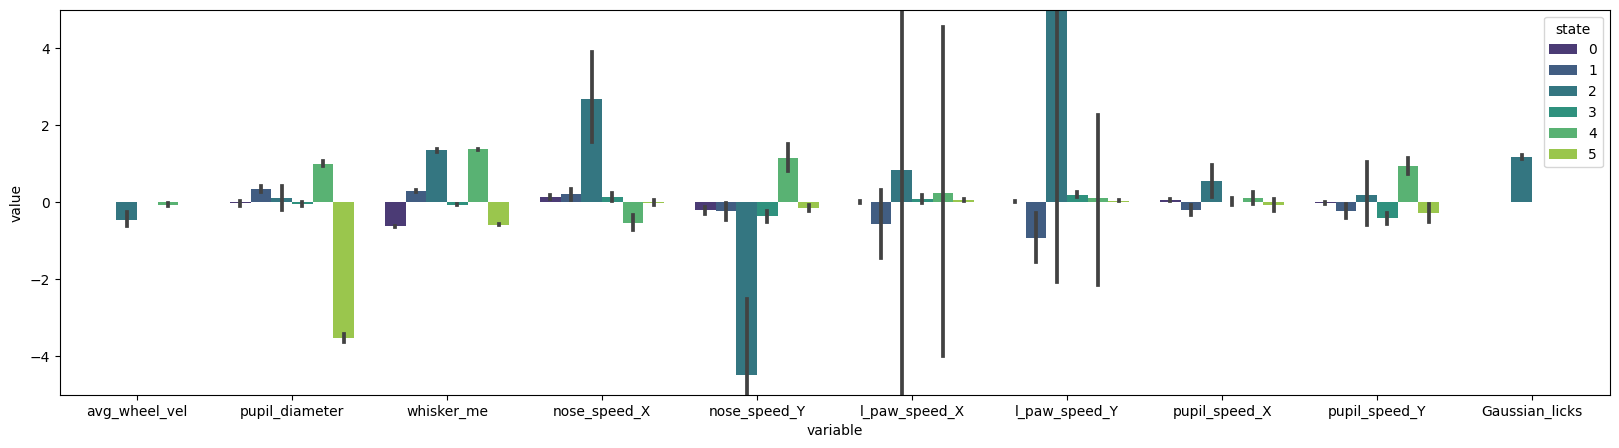

In [11]:
fig, ax = plt.subplots(figsize=[20, 5])
sns.barplot(x='variable', y='value', hue='state', data=melted, palette='viridis')
plt.ylim([-5, 5])

(-5.0, 5.0)

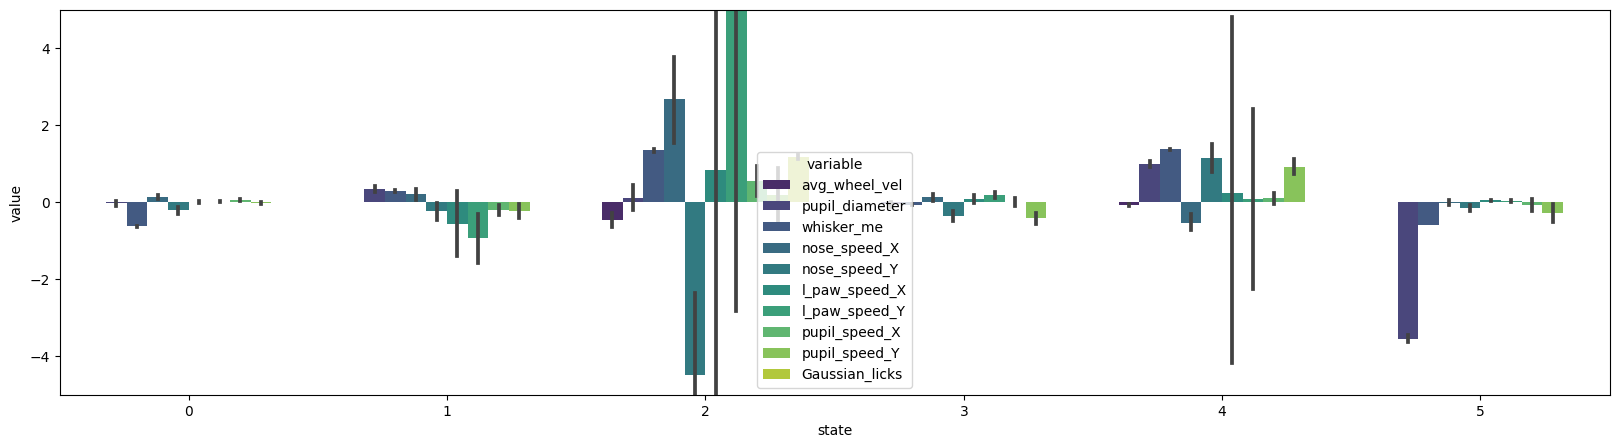

In [12]:
fig, ax = plt.subplots(figsize=[20, 5])
sns.barplot(hue='variable', y='value', x='state', data=melted, palette='viridis')
plt.ylim([-5, 5])

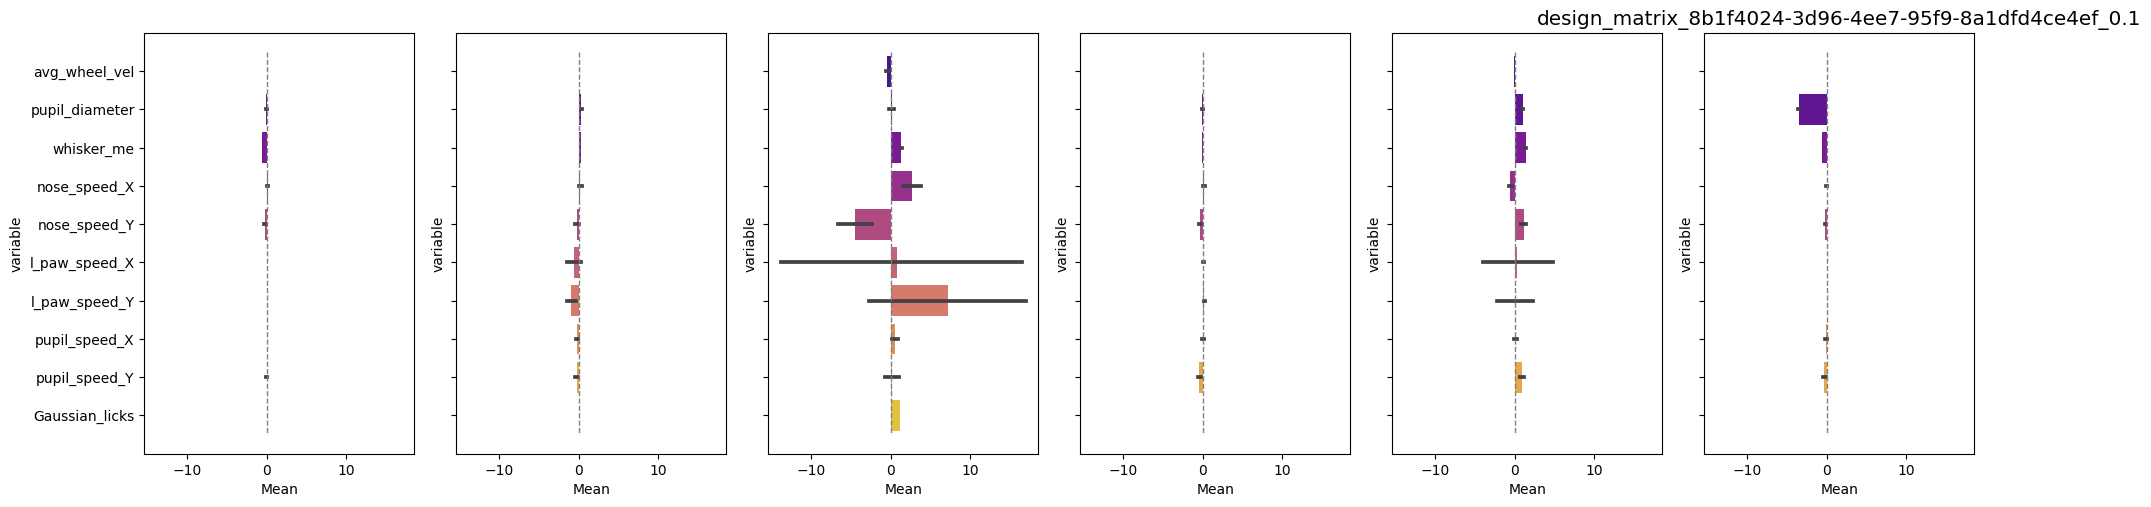

In [13]:

states = []
for s in range(num_states):
    state = 'State ' + str(s)
    states.append(state) 
        
fig, ax = plt.subplots(ncols=len(states) , nrows=1, sharex=True, sharey=True, figsize=[20, 5])
plt.rc('font', size=12)

for s, state in enumerate(states):
    use_data = melted.loc[melted['state']==s]
    sns.barplot(y='variable', x='value', data=use_data, ax=ax[s], palette='plasma')
    ax[s].vlines(0, -.50, 9.5, color='Gray', linestyles='--', linewidth=1)
    ax[s].set_xlabel('Mean')
    #ax[s].set_title(state)

plt.tight_layout()
plt.title(ses)
plt.show()
    

## PCA on data samples

In [22]:
"""
PRINCIPLE COMPONENT ANALYSES
"""

X = matrix_all[ses][0] # (n_samples, n_features)

# Mean centered and equal variance (redundant code)
scaler = StandardScaler()
scaler.fit(X)

pca = PCA() # svd_solver='full'
#pca.fit(scaler.transform(X))
X_reduced = pca.fit_transform(scaler.transform(X))
X_reduced = pca.fit_transform(X)


In [23]:
# Plot projections of datapoints into first 3 principal components
augmented_data = pd.DataFrame(columns=['state'], index=range(len(X_reduced)))
augmented_data['state'] = most_likely_states
augmented_data['pc1'] = X_reduced[:, 0].transpose()
augmented_data['pc2'] = X_reduced[:, 1].transpose()
augmented_data['pc3'] = X_reduced[:, 2].transpose()
augmented_data['pc4'] = X_reduced[:, 3].transpose()
augmented_data['pc5'] = X_reduced[:, 4].transpose()
augmented_data['pc6'] = X_reduced[:, 5].transpose()
augmented_data['pc7'] = X_reduced[:, 6].transpose()
augmented_data['pc8'] = X_reduced[:, 7].transpose()
augmented_data['pc9'] = X_reduced[:, 8].transpose()
augmented_data['pc10'] = X_reduced[:, 9].transpose()

Text(0, 0.5, '% Variance explained')

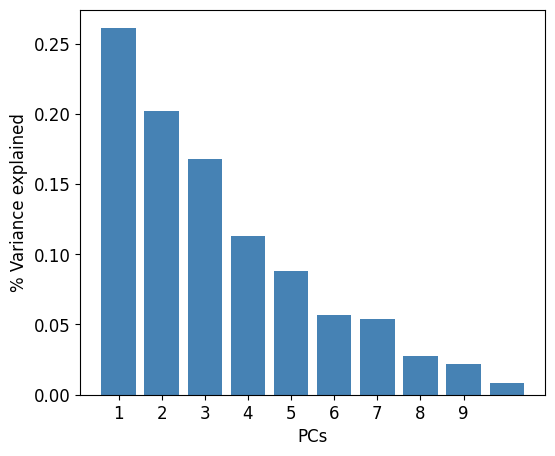

In [24]:
# Plot variance explained per principle component
fig, ax = plt.subplots(figsize=[6,5])
plt.rc('font', size=18)
keep_pc = np.shape(X)[1]
plt.bar(np.arange(1, keep_pc+1, 1), pca.explained_variance_ratio_[0:keep_pc], color='steelblue')
plt.xticks(np.arange(1, keep_pc, 1))
#plt.xlim([0, 3])
plt.xlabel('PCs')
plt.ylabel('% Variance explained')

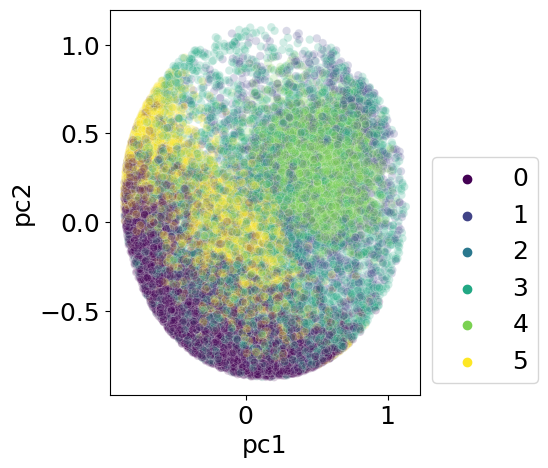

In [25]:
fig, axs = plt.subplots(figsize=[4, 5])
sns.scatterplot(x='pc1', y='pc2', data=augmented_data, alpha=0.2, hue='state', palette='viridis')
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.65))


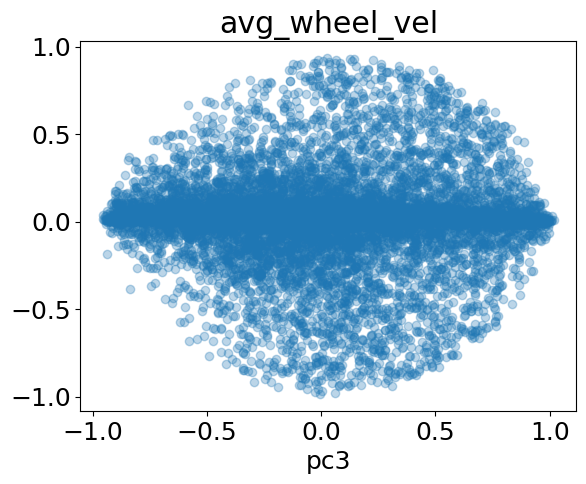

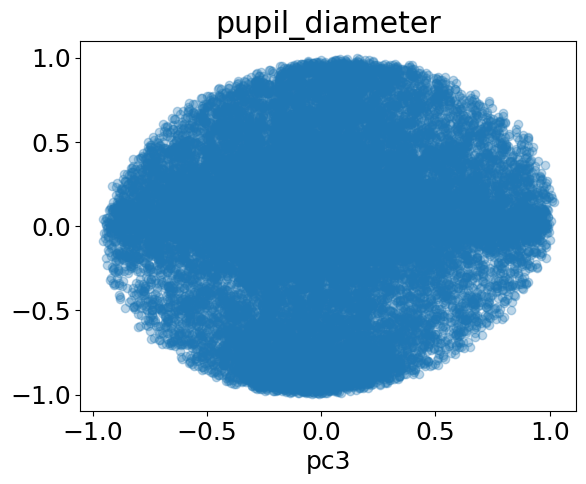

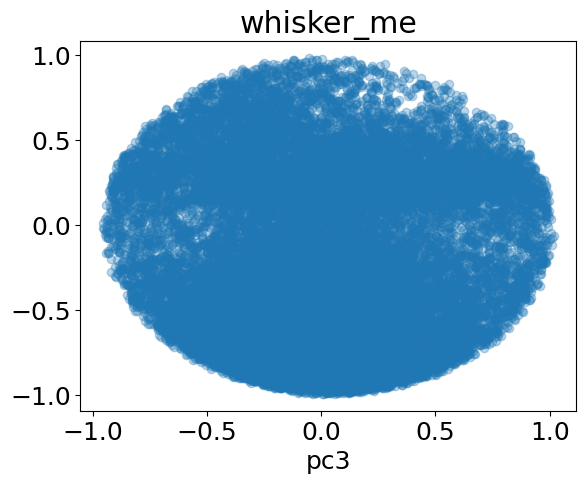

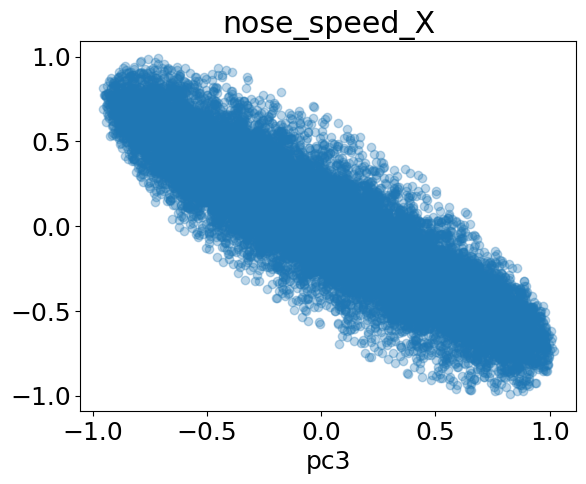

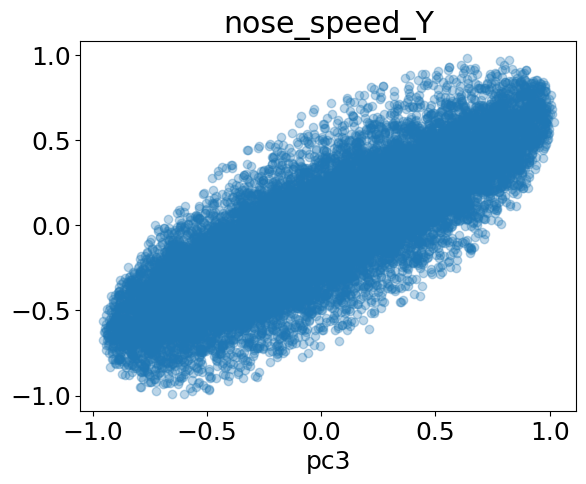

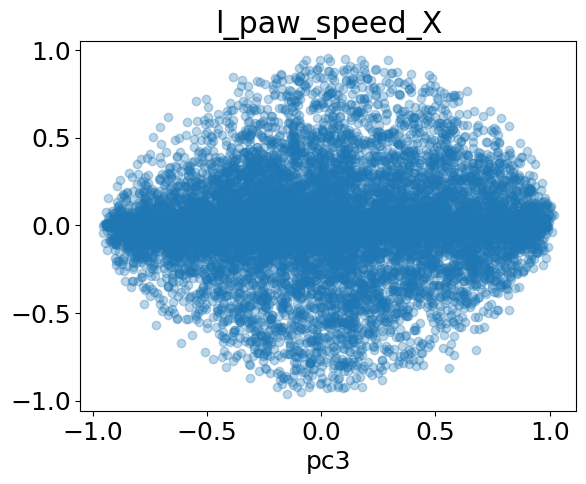

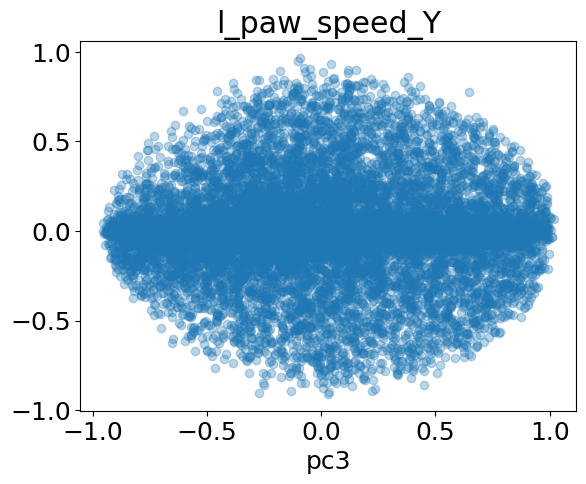

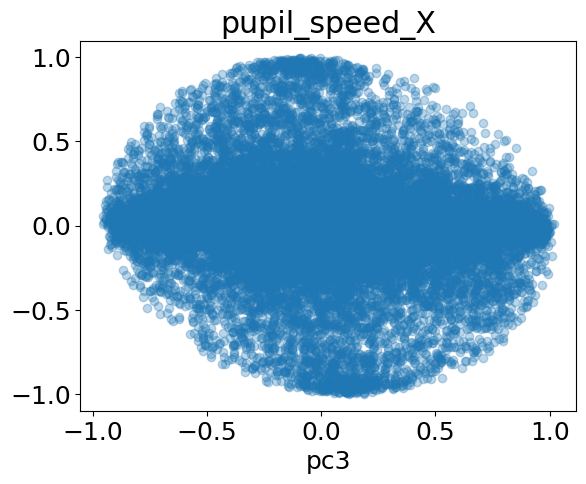

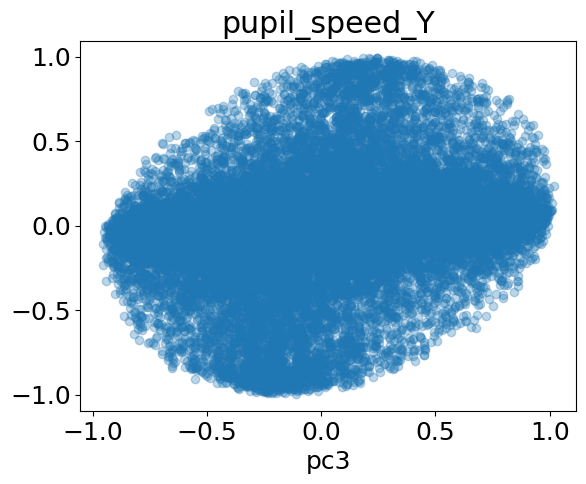

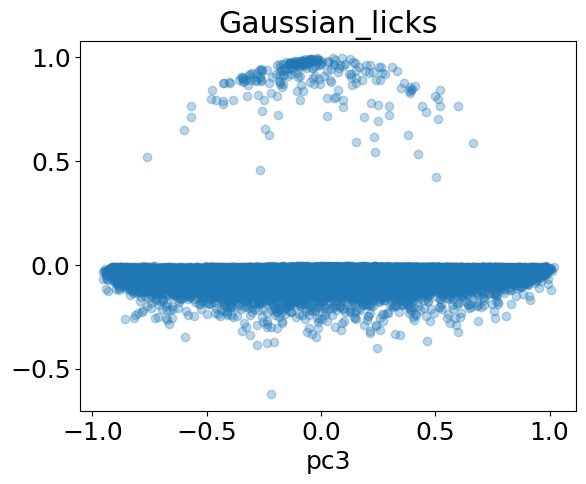

In [29]:
pc = 'pc3'
for v, var in enumerate(var_names):
    plt.scatter(np.array(augmented_data[pc]), X[:, v], alpha=0.3)
    plt.xlabel(pc)
    plt.title(var)
    plt.show()

## PCA on state space

In [14]:
num_states = len(states)
X_learned_params = []
for s, state in enumerate(range(num_states)):
    
    df = pd.DataFrame(columns=[var_names ], index=range(1))
    for v, var in enumerate(var_names):
        value = np.nanmean(fit_params[2].means[:].T[v][s, :])
        df[var] = value
    #learned_params = learned_params.append(df)
    if s == 0:
        X_learned_params = np.array(df)
    else:
        X_learned_params = np.vstack((X_learned_params, np.array(df)))

In [15]:
"""
PRINCIPLE COMPONENT ANALYSES
"""

X = X_learned_params # (n_samples, n_features)

# Mean centered and equal variance (redundant code)
scaler = StandardScaler()
scaler.fit(X)

pca = PCA() # svd_solver='full'
#pca.fit(scaler.transform(X))
X_reduced = pca.fit_transform(scaler.transform(X))


In [17]:
# Plot projections of datapoints into first 3 principal components
augmented_data = pd.DataFrame(columns=['state'], index=range(num_states))
augmented_data['state'] = range(num_states)
augmented_data['pc1'] = X_reduced[:, 0].transpose()
augmented_data['pc2'] = X_reduced[:, 1].transpose()
augmented_data['pc3'] = X_reduced[:, 2].transpose()
augmented_data['pc4'] = X_reduced[:, 3].transpose()
augmented_data['pc5'] = X_reduced[:, 4].transpose()
augmented_data['pc6'] = X_reduced[:, 5].transpose()
augmented_data['pc7'] = X_reduced[:, 6].transpose()
augmented_data['pc8'] = X_reduced[:, 7].transpose()
augmented_data['pc9'] = X_reduced[:, 8].transpose()
augmented_data['pc10'] = X_reduced[:, 9].transpose()

Text(0, 0.5, '% Variance explained')

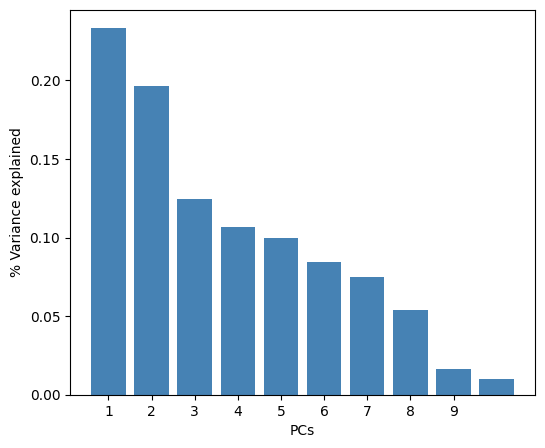

In [18]:
# Plot variance explained per principle component
fig, ax = plt.subplots(figsize=[6,5])
plt.rc('font', size=18)
keep_pc = np.shape(X)[1]
plt.bar(np.arange(1, keep_pc+1, 1), pca.explained_variance_ratio_[0:keep_pc], color='steelblue')
plt.xticks(np.arange(1, keep_pc, 1))
#plt.xlim([0, 3])
plt.xlabel('PCs')
plt.ylabel('% Variance explained')

(-5.0, 5.0)

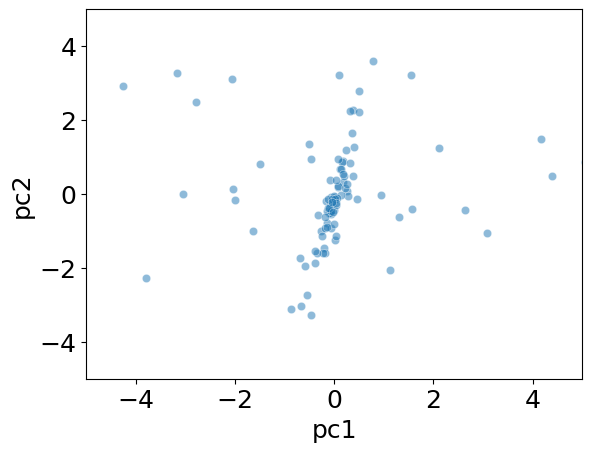

In [19]:
sns.scatterplot(x='pc1', y='pc2', data=augmented_data, alpha=0.5)
plt.xlim([-5, 5])
plt.ylim([-5, 5])

In [ ]:
augmented_data
var_names = ['avg_wheel_vel', 'pupil_diameter',
    'whisker_me', 'nose_speed_X', 'nose_speed_Y', 
    'l_paw_speed_X', 'l_paw_speed_Y', 'pupil_speed_X',
    'pupil_speed_Y', 'Gaussian_licks']

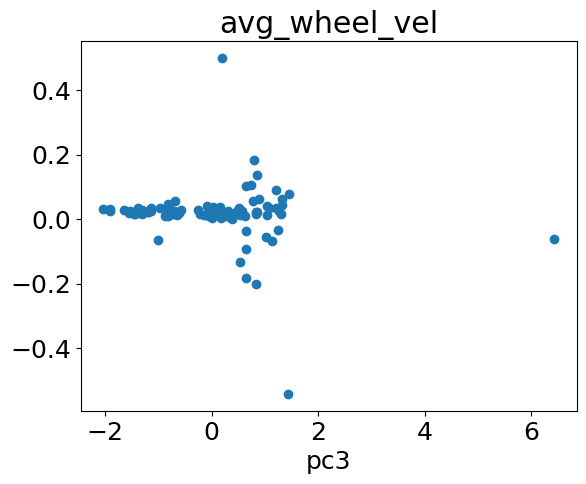

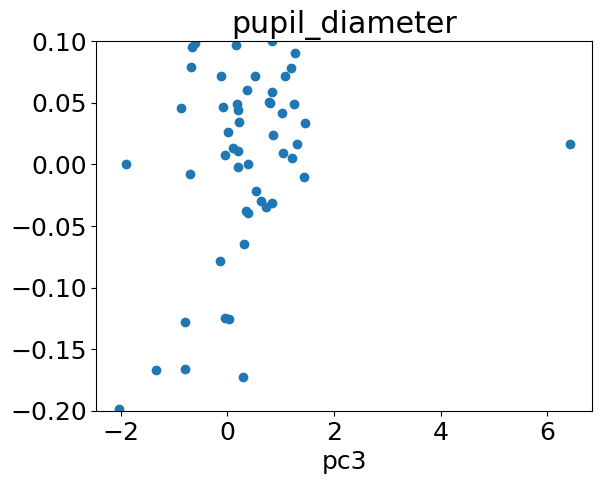

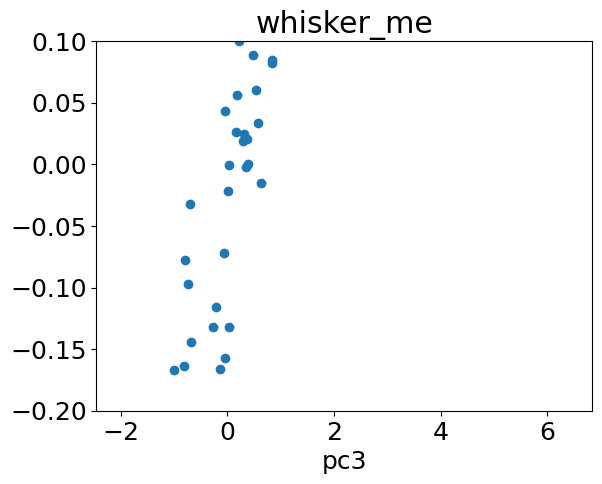

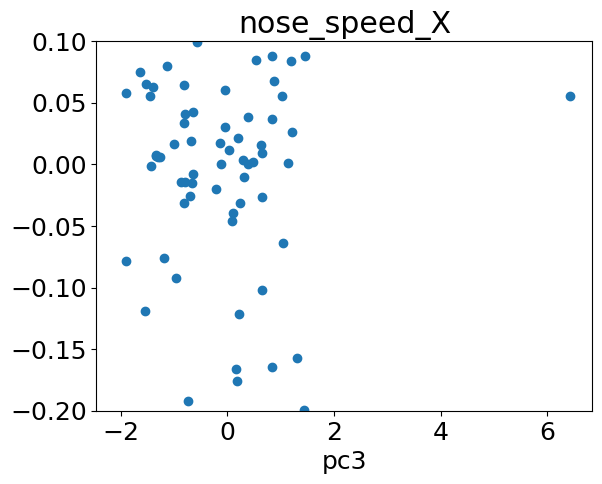

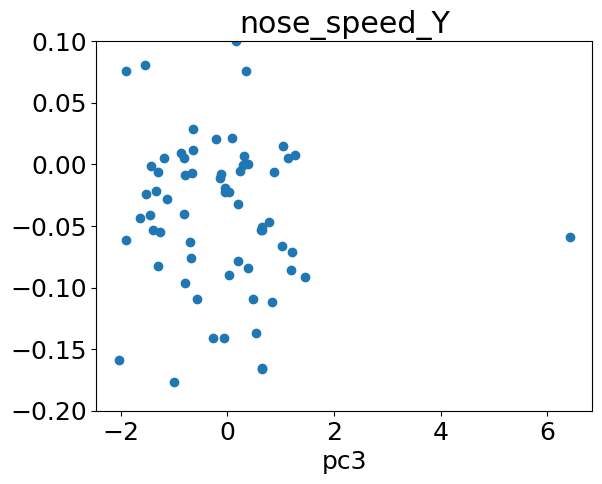

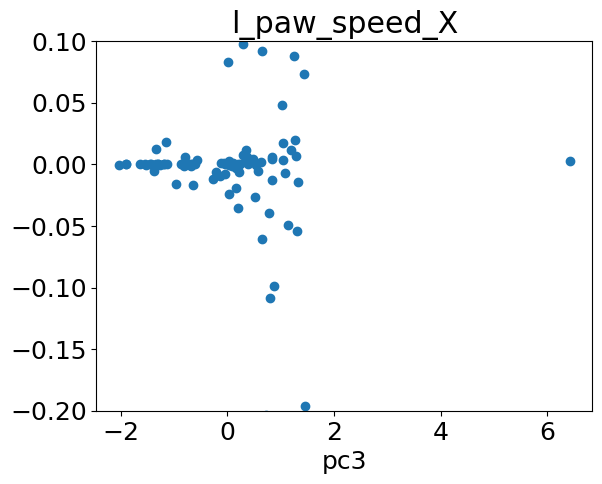

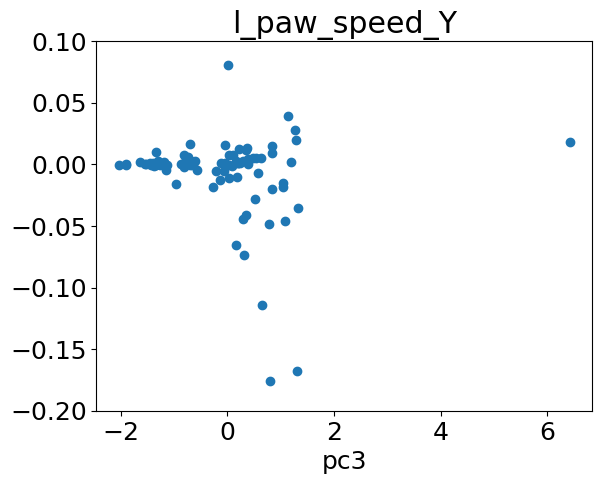

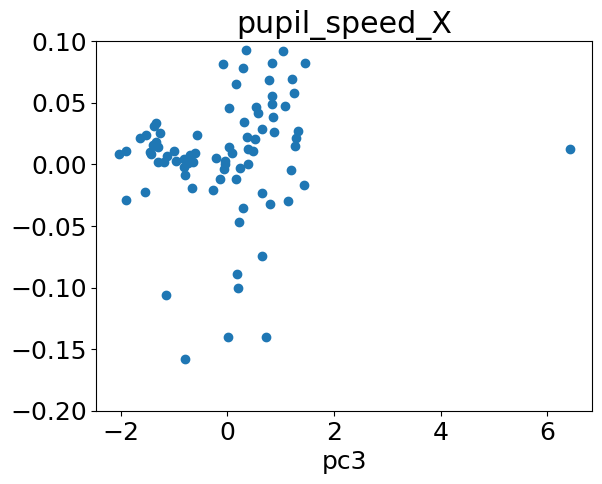

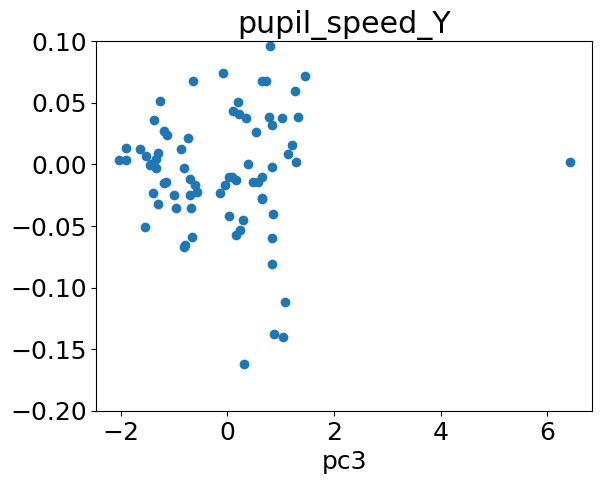

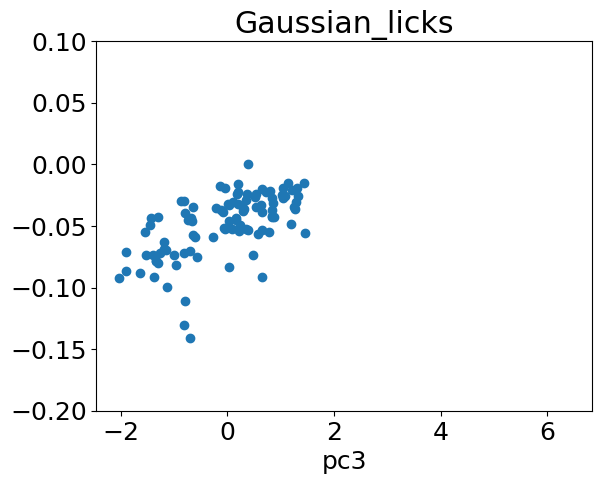

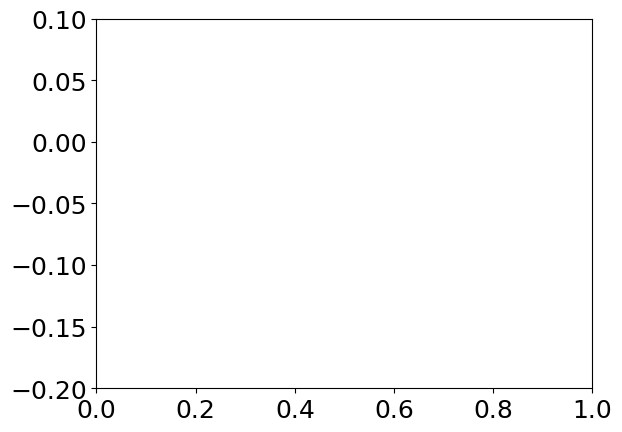

In [53]:
pc = 'pc3'
for v, var in enumerate(var_names):
    plt.scatter(np.array(augmented_data[pc]), X_learned_params[:, v])
    plt.xlabel(pc)
    plt.title(var)
    plt.show()


In [ ]:
data_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix'

os.chdir(data_path)

pickle.dump(augmented_data, open("design_matrix_dim_reduc", "wb"))

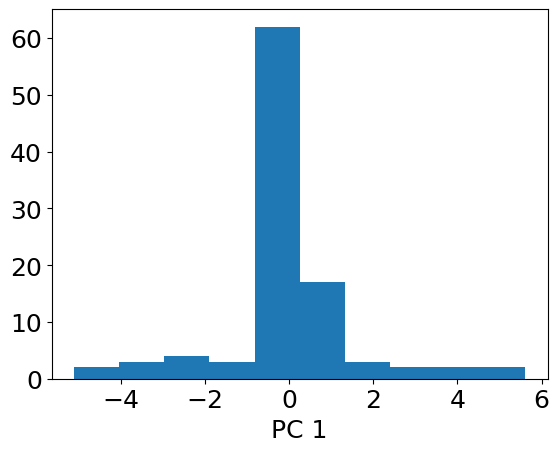

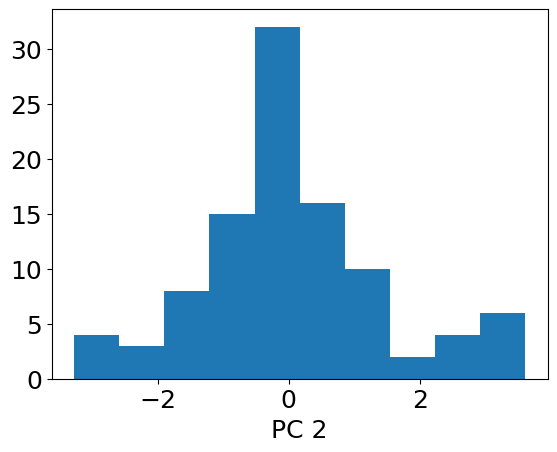

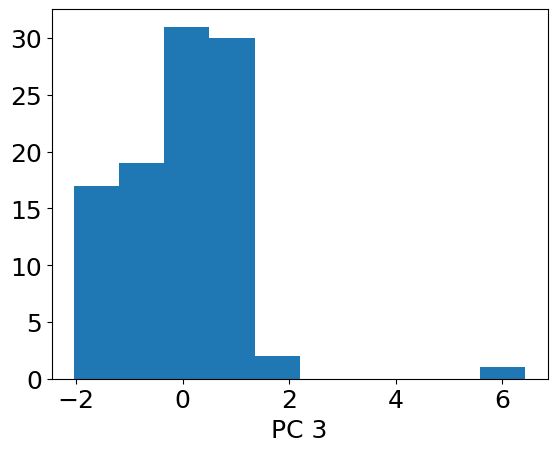

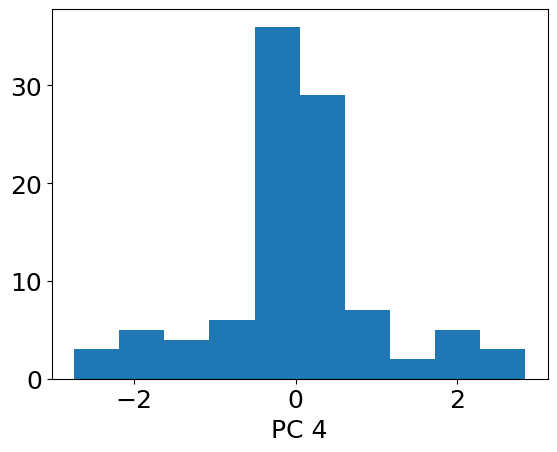

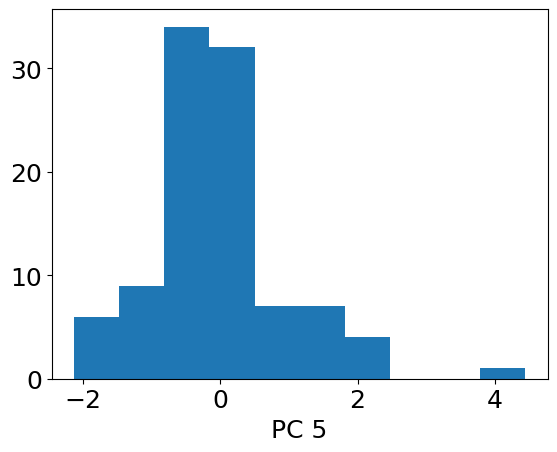

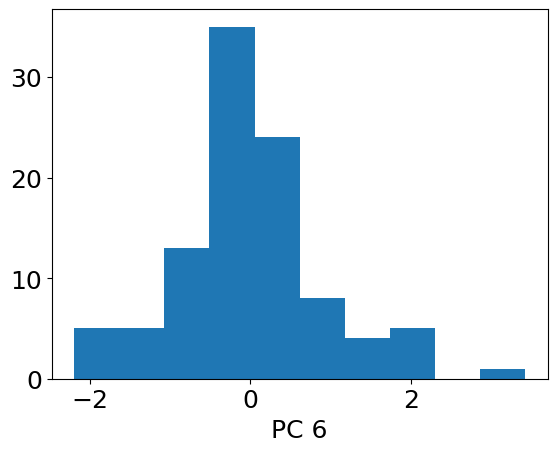

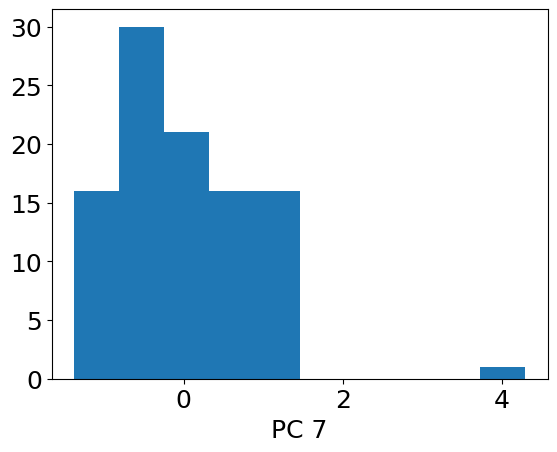

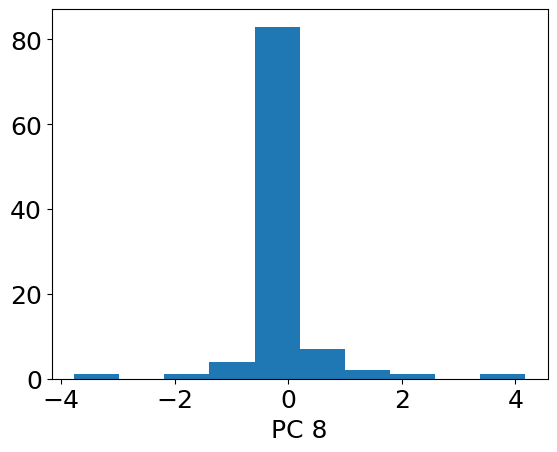

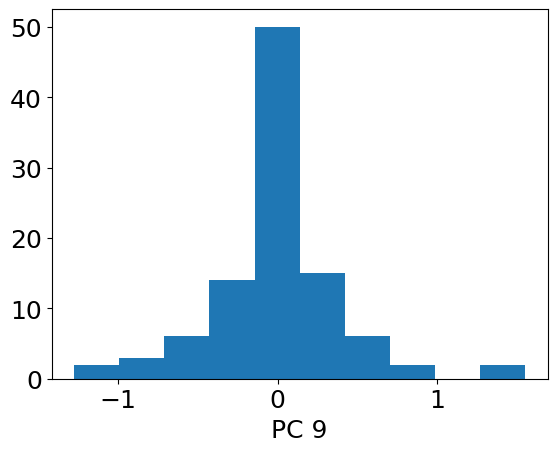

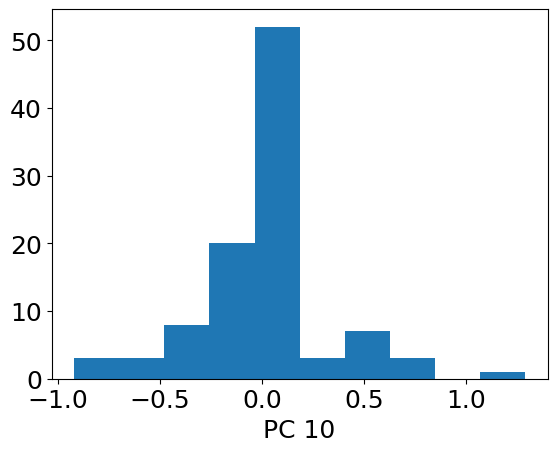

IndexError: index 10 is out of bounds for axis 1 with size 10

In [49]:
plt.hist(X_reduced[:,0])
plt.xlabel('PC 1')
plt.show()

plt.hist(X_reduced[:,1])
plt.xlabel('PC 2')
plt.show()

plt.hist(X_reduced[:,2])
plt.xlabel('PC 3')
plt.show()

plt.hist(X_reduced[:,3])
plt.xlabel('PC 4')
plt.show()

plt.hist(X_reduced[:,4])
plt.xlabel('PC 5')
plt.show()

plt.hist(X_reduced[:,5])
plt.xlabel('PC 6')
plt.show()

plt.hist(X_reduced[:,6])
plt.xlabel('PC 7')
plt.show()

plt.hist(X_reduced[:,7])
plt.xlabel('PC 8')
plt.show()

plt.hist(X_reduced[:,8])
plt.xlabel('PC 9')
plt.show()

plt.hist(X_reduced[:,9])
plt.xlabel('PC 10')
plt.show()

plt.hist(X_reduced[:,10])
plt.xlabel('PC 11')
plt.show()